# Preprocessing

Filtering out for only systems within Q1-Q3 of the kwp range, and performing PCA on the power values directly (rather than using the reconstructions)

In [2]:
### Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

# import ipyleaflet as ipy

from pyspark import SparkContext
import pyspark.sql.functions as F
import pyspark.ml.functions as M
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.linalg import Vectors

import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

Matplotlib created a temporary cache directory at /tmp/matplotlib-3e1qscdj because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
### For server
# 32 nodes
# 64g

## Start Spark context
total_nodes = 20
memory_per_node = 200

driver_memory = f"{memory_per_node}g"
executor_memory = f"{int(memory_per_node/total_nodes)}g"
n_executors = total_nodes - 1
print(f"Driver memory: {driver_memory}\nExecutor memory: {executor_memory}\nNumber of executors: {n_executors}\n")
try:
    print("Initializing SparkContext")
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .getOrCreate()
except:
    print("Starting new SparkContext")
    sc.stop()
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .appName("MyApp") \
                             .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.4") \
                             .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
                             .getOrCreate()
print(sc)

# Start SQL Context
sqlContext = SQLContext(sc)

sc.getActiveSession()

Driver memory: 200g
Executor memory: 10g
Number of executors: 19

Initializing SparkContext


/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
%%time
### Load datasets
df_type = 30

### Open the preprocessed dataset
df = sqlContext.read.load("preprocessed_df_single_2/preprocessed_df_1.parquet")
# df_count = df.count()

# metadata
meta_filename = "metadata_preprocessed.csv"
df_meta = sc.read.csv(meta_filename, inferSchema=True, header=True)
# df_meta_count = df_meta.count()

### Comments
# print(f"30min dataset has {df_count} rows")
# df.show(3)
# print(f"Meta dataset has {df_meta_count} rows")
# df_meta.show(3)
# print("/nTable schemas/n")
# print(f"Schema of the {df_type} min time series data table") ###
# df.printSchema()
# print("Schema of the metadata table")
# df_meta.printSchema()

### Since metadata table is so small, convert to Pandas
df_meta = df_meta.toPandas()

CPU times: user 77.1 ms, sys: 9.54 ms, total: 86.7 ms
Wall time: 3.24 s


In [5]:
%%time
### Calculate the power kwp cutoffs

high_kwp_cutoff = df_meta["kwp"].quantile(0.75)
low_kwp_cutoff = df_meta["kwp"].quantile(0.25)

print("Filtering for systems where kwp <=", high_kwp_cutoff, "and kwp >=", low_kwp_cutoff)

ss_id_list = list(df_meta[(df_meta["kwp"] <= high_kwp_cutoff) & (df_meta["kwp"] >= low_kwp_cutoff)]["ss_id"])
# df.unpersist()
df2 = df.where(F.col("ss_id").isin(ss_id_list)).cache()

df2.count()

Filtering for systems where kwp <= 3.42 and kwp >= 2.28
CPU times: user 905 ms, sys: 200 ms, total: 1.1 s
Wall time: 1min 37s


28087986

In [6]:
%%time
### Comparing the mean generation curve with the mean reconstruction curve
df_power = df.select("id", F.posexplode("power_kW_values")) \
              .groupBy("pos") \
              .agg(F.mean("col").alias("mean_power"),
                   F.std("col").alias("std_power")) \
              .toPandas()

df_recon = df.select("id", F.posexplode("reconstructions")) \
              .groupBy("pos") \
              .agg(F.mean("col").alias("mean_recon"),
                   F.std("col").alias("std_recon")) \
              .toPandas()


CPU times: user 13.5 ms, sys: 2.37 ms, total: 15.8 ms
Wall time: 43.7 s


In [7]:
%%time
### Comparing the mean generation curve with the mean reconstruction curve
df2_power = df2.select("id", F.posexplode("power_kW_values")) \
              .groupBy("pos") \
              .agg(F.mean("col").alias("mean_power"),
                   F.std("col").alias("std_power")) \
              .toPandas()

df2_recon = df2.select("id", F.posexplode("reconstructions")) \
              .groupBy("pos") \
              .agg(F.mean("col").alias("mean_recon"),
                   F.std("col").alias("std_recon")) \
              .toPandas()


CPU times: user 10.4 ms, sys: 3.02 ms, total: 13.4 ms
Wall time: 38.8 s


CPU times: user 81.5 ms, sys: 8.11 ms, total: 89.6 ms
Wall time: 90.5 ms


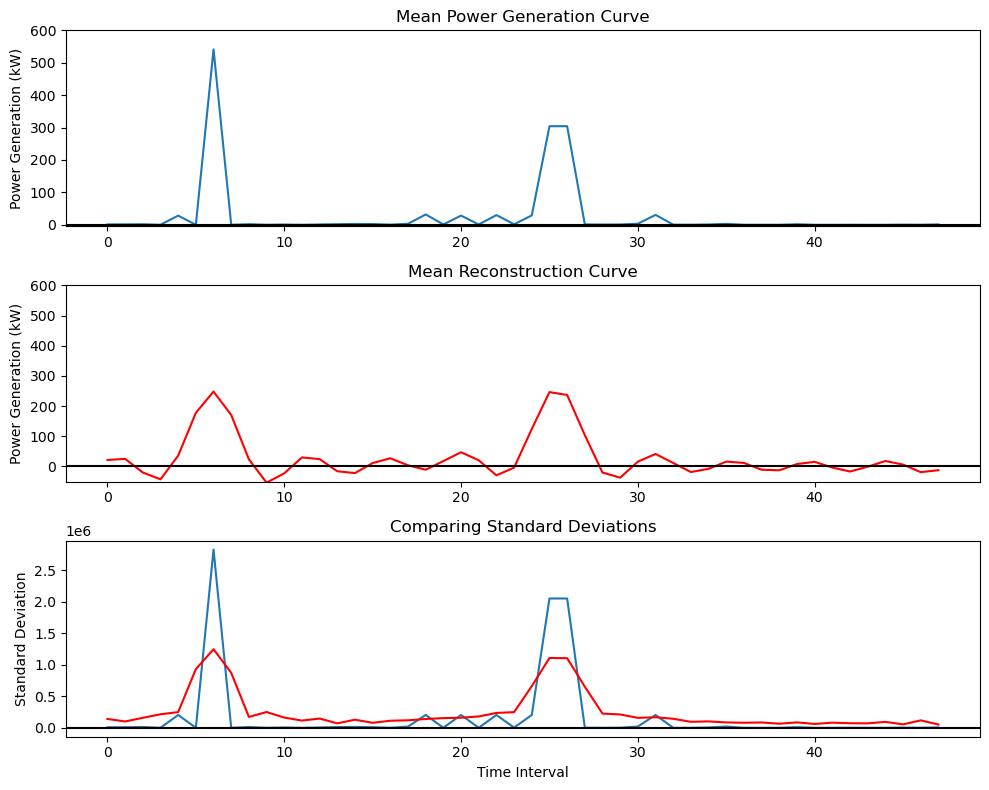

In [8]:
%%time
### Plotting
df_power = df_power.sort_values("pos")
df_recon = df_recon.sort_values("pos")

fig,ax = plt.subplots(3, 1, figsize=(10,8))
ax[0].plot(df_power["pos"], df_power["mean_power"])
ax[0].axhline(0, 0, 48, c="k")
ax[0].set_title("Mean Power Generation Curve")
ax[0].set_ylabel("Power Generation (kW)")
ax[0].set_ylim([-5, 600])
ax[1].plot(df_recon["pos"], df_recon["mean_recon"], color="r")
ax[1].axhline(0, 0, 48, c="k")
ax[1].set_title("Mean Reconstruction Curve")
ax[1].set_ylabel("Power Generation (kW)")
ax[1].set_ylim([-50, 600])
ax[2].plot(df_power["pos"], df_power["std_power"])
ax[2].plot(df_recon["pos"], df_recon["std_recon"], color="r")
ax[2].set(title="Comparing Standard Deviations", ylabel="Standard Deviation", xlabel="Time Interval")
ax[2].axhline(0, 0, 48, c="k")

plt.tight_layout()

In [9]:
df2_power.describe()

,pos,mean_power,std_power
count,48.00,48.000000,48.000000
mean,23.50,0.285660,66.014818
std,14.00,0.345193,105.230689
min,0.00,-0.014710,0.002111
25%,11.75,0.000068,0.014698
50%,23.50,0.089824,0.469769
75%,35.25,0.590961,78.026948
max,47.00,0.928558,337.278300


In [10]:
df2_recon.describe()

,pos,mean_recon,std_recon
count,48.00,48.000000,48.000000
mean,23.50,0.285660,42.536466
std,14.00,0.344755,27.691266
min,0.00,-0.012005,12.494502
25%,11.75,0.005765,22.350223
50%,23.50,0.086615,32.986760
75%,35.25,0.584091,56.285080
max,47.00,0.930322,141.313216


CPU times: user 63.6 ms, sys: 3.01 ms, total: 66.6 ms
Wall time: 66.6 ms


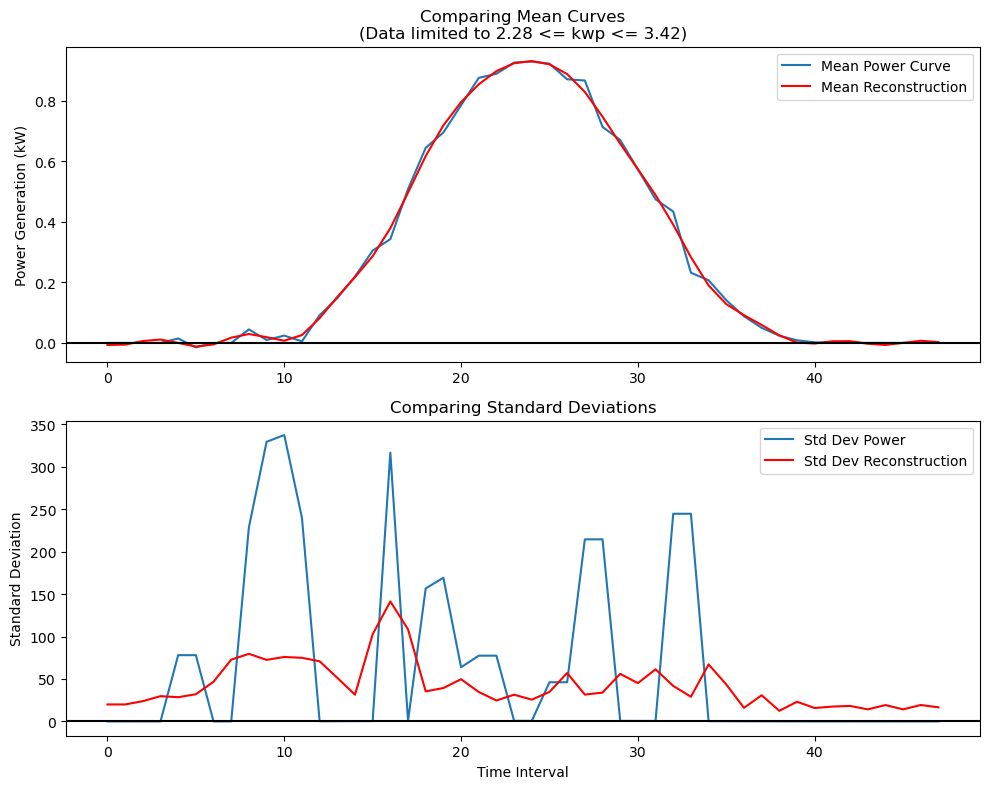

In [11]:
%%time
### Plotting
df2_power = df2_power.sort_values("pos")
df2_recon = df2_recon.sort_values("pos")

fig,ax = plt.subplots(2, 1, figsize=(10,8))
ax[0].plot(df2_power["pos"], df2_power["mean_power"], label="Mean Power Curve")
ax[0].plot(df2_recon["pos"], df2_recon["mean_recon"], color="r", label="Mean Reconstruction")
ax[0].axhline(0, 0, 48, c="k")
ax[0].set_title("Comparing Mean Curves\n(Data limited to 2.28 <= kwp <= 3.42)")
ax[0].set_ylabel("Power Generation (kW)")
ax[0].legend()
# ax[0].set_ylim([-5, 600])
ax[1].plot(df2_power["pos"], df2_power["std_power"], label="Std Dev Power")
ax[1].plot(df2_recon["pos"], df2_recon["std_recon"], color="r", label="Std Dev Reconstruction")
ax[1].legend()
ax[1].set(title="Comparing Standard Deviations", ylabel="Standard Deviation", xlabel="Time Interval")
ax[1].axhline(0, 0, 48, c="k")

plt.tight_layout()

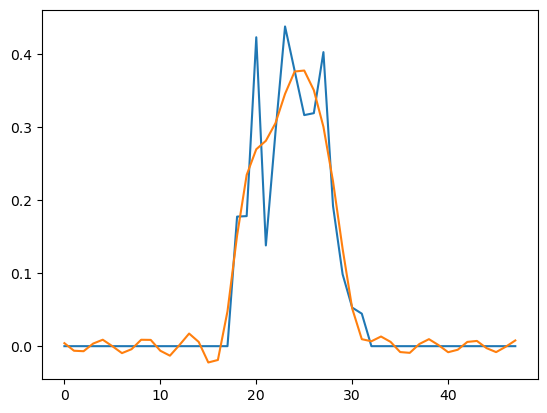

In [12]:
test_power = np.array(df2.select("power_kW_values").take(1)[0][0])
test_recon = np.array(df2.select("reconstructions").take(1)[0][0])

x = np.array([i for i in np.arange(0, 48)])
plt.plot(x, test_power)
plt.plot(x, test_recon)



# Getting Coefficient PCAs and Top 2 PCs

In [13]:
### Visualize the dataset by reducing power_kW_values to 2 Dimensions

### Define function to get covariance and other related stats
def compute_covariance_matrix(df, col):
    ### Map steps --> Incorporating NaN handling
    # 1: Create an array and insert 1 into element 0 (vec_length being max_timestamps + 1)
    # 2: Get the outer product of the array and indices of non-null values (as 1)
    # 3: Reduce to get two matrices: matrix sum and non-null indices
    sums_nonNullCounts =  df.select(col) \
                            .rdd.map(lambda a: (np.array([1] + a[0]))) \
                                .map(lambda b: (np.outer(b, b), 1-np.outer(b,b))) \
                                .reduce(lambda c1, c2: (np.nansum(np.dstack((c1[0], c2[0])), axis=2), c1[1] + c2[1])) \

    # S: Sum, NNC: Non-Null Count
    S, N = sums_nonNullCounts

    # Get E(x) --> Ex = Mean of df2_S[0, 1:]
    S_x = S[0, 1:]
    NNC_x = N[0, 1:]
    Ex = S_x/NNC_x

    # Get E(xxT) --> ExxT = Mean of df2_S[1:,1:]
    S_xxT = S[1:, 1:]
    NNC_xxT = N[1:, 1:]
    ExxT = S_xxT/NNC_xxT

    # Get covariance
    cov = ExxT - np.outer(Ex, Ex)

    output = [cov, Ex]

    return output

def get_ordered_eigval_eigvec(cov):
    ### Extract the eigenvalues and eigenvectors, then output them ordered by eigenvalue magnitude
    eigval, eigvec = np.linalg.eig(cov)
    eigval_ind = np.argsort(np.absolute(eigval))[::-1]
    output = [eigval[eigval_ind], eigvec[eigval_ind]]
    
    return output

def plot_explained_variance(eigval, max_num = None):
    ### View the amount of variance explained by each eigvenvector
    if max_num is None:
        max_num = len(eigval)
    total_var = np.sum(np.absolute(eigval))
    explained_var = []
    for i in range(0,max_num):
        explained_var.append((sum(np.absolute(eigval[:i])) / total_var) * 100)
        print(f"Up to vector {i}: {explained_var[i]}")
        
    plt.plot(range(0,max_num), explained_var)
    plt.title("Variance Explained by Eigenvectors")
    plt.xlabel("Number of Eigenvectors")
    plt.ylabel("% of Variance Explained")
    plt.show()




In [14]:
### PCA to visualize variance
col = "reconstructions"
### Calculate covariance matrix
recon_cov, recon_colMeans = compute_covariance_matrix(df2, col)
### Perform eigenvalue decomposition to get eigenvalues/eigenvectors of covariance matrix
recon_eigval, recon_eigvec = get_ordered_eigval_eigvec(recon_cov)

### PCA on coefficients to visualize them
col = "power_kW_values"
### Calculate covariance matrix
cov, colMeans = compute_covariance_matrix(df2, col)
### Perform eigenvalue decomposition to get eigenvalues/eigenvectors of covariance matrix
eigval, eigvec = get_ordered_eigval_eigvec(cov)

Up to vector 0: 0.0
Up to vector 1: 38.405664969277204
Up to vector 2: 72.90352595595797
Up to vector 3: 84.82097490877287
Up to vector 4: 92.12945729641932
Up to vector 5: 96.64244581154277
Up to vector 6: 97.82557542900801
Up to vector 7: 98.740565512941
Up to vector 8: 99.17531974282404
Up to vector 9: 99.59014859658741


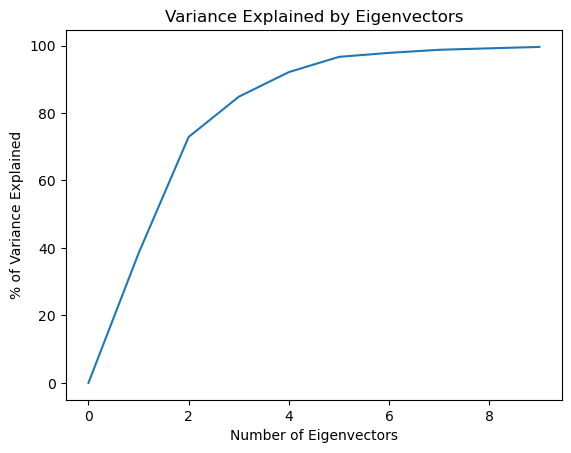

In [15]:
### Plot the amount of explained variance
plot_explained_variance(eigval, 10)

Variance Explained From Power Decomposition
Up to vector 0: 0.0
Up to vector 1: 38.405664969277204
Up to vector 2: 72.90352595595797
Up to vector 3: 84.82097490877287
Up to vector 4: 92.12945729641932
Up to vector 5: 96.64244581154277
Up to vector 6: 97.82557542900801
Up to vector 7: 98.740565512941
Up to vector 8: 99.17531974282404
Up to vector 9: 99.59014859658741

Variance Explained From Reconstruction Decomposition
Up to vector 0: 0.0
Up to vector 1: 93.3343597142811
Up to vector 2: 98.28387629845284
Up to vector 3: 98.74502632367134
Up to vector 4: 99.18786545584199
Up to vector 5: 99.28789916209904
Up to vector 6: 99.38182496564164
Up to vector 7: 99.43294352369836
Up to vector 8: 99.48344906983586
Up to vector 9: 99.53028333927935



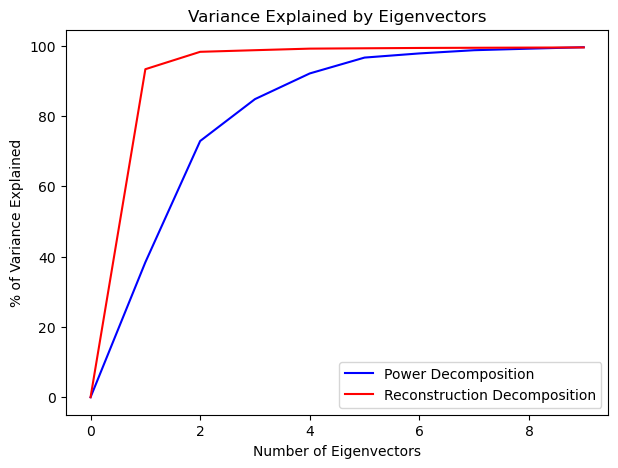

In [16]:
### Comparing variance explained
max_num=10
fig, axes = plt.subplots(1,1, figsize=(7,5))
eig = [eigval, recon_eigval]
labels = ["Power Decomposition", "Reconstruction Decomposition"]
colors = ["b", "r"]

# fig,ax = plt.subplots(1,1, figsize=(6,5))
for j, eigval_i in enumerate(eig):
    total_var = np.sum(np.absolute(eigval_i))
    explained_var = []
    print("Variance Explained From", labels[j])
    for i in range(0,max_num):
        explained_var.append((sum(np.absolute(eigval_i[:i])) / total_var) * 100)
        print(f"Up to vector {i}: {explained_var[i]}")
    print()
    plt.plot(range(0,max_num), explained_var, label=labels[j], color=colors[j])
    plt.title("Variance Explained by Eigenvectors")
    plt.xlabel("Number of Eigenvectors")
    plt.ylabel("% of Variance Explained")
plt.legend()
plt.show()

In [17]:
df2.show(1)

+---+-----+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|ss_id|stamp_date|     power_kW_values|        coefficients|     reconstructions|                  PC|                 PC1|                 PC2|
+---+-----+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0| 2405|2012-01-21|[0.0, 0.0, 0.0, 0...|[0.49785779737625...|[0.00410907621307...|[-0.4178259582696...|-0.41782595826965074|-0.02458836598737569|
+---+-----+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 1 row



In [18]:
### Get a representation for each data point along the 2 principal components
def get_top2_PC(df, eigvec):
    ### Convert dataframe coefficient to top 2 principal components
    # input: id, ss_id, stamp_date, power_kW_values, coefficients, reconstructions
    # output: id, ss_id, stamp_date, power_kW_values, coefficients, reconstructions, pc, pc1, pc2
    output = df.rdd.map(lambda a: ((a[0], a[1], a[2], a[3], a[4], a[5], a[6], a[7], a[8]), np.nan_to_num(np.array(a[5])).reshape(1, len(a[5])), 2)) \
               .map(lambda b: (b[0], np.dot(b[1], eigvec[0:2].T))) \
               .map(lambda b: (b[0][0], b[0][1], b[0][2], b[0][3], b[0][4], b[0][5], b[0][6], b[0][7], b[0][8], b[1][0].tolist(), float(b[1][0][0]), float(b[1][0][1]))) \
               .toDF(["id", "ss_id", "stamp_date", "power_kW_values", "coefficients", "reconstructions", "recon_PC", "recon_PC1", "recon_PC2", "power_PC", "power_PC1", "power_PC2"])

    return output

df3 = get_top2_PC(df2, eigvec)

df3.show(1, vertical=True)

-RECORD 0-------------------------------
 id              | 0                    
 ss_id           | 2405                 
 stamp_date      | 2012-01-21           
 power_kW_values | [0.0, 0.0, 0.0, 0... 
 coefficients    | [0.49785779737625... 
 reconstructions | [0.00410907621307... 
 recon_PC        | [-0.4178259582696... 
 recon_PC1       | -0.41782595826965074 
 recon_PC2       | -0.02458836598737569 
 power_PC        | [-0.0129104585327... 
 power_PC1       | -0.01291045853276512 
 power_PC2       | 0.002746521891096... 
only showing top 1 row



In [19]:
### Saving the covariance matrix
pd.DataFrame(cov).to_csv("datasets/power_cov.csv", header=False, index=False)

In [20]:
### Saving the column means
pd.DataFrame(colMeans).to_csv("datasets/power_means.csv", header=False, index=False)

In [21]:
### Saving the new preprocessed df
df3.repartition(1).write.mode("overwrite").parquet("preprocessed_df_single_3")